#INSTALLING DEPENDENCIES

In [6]:
!pip install python-dotenv
!pip install beautifulsoup4
!pip install langchain
!pip install langchain-community
!pip install faiss-cpu  # Or faiss-gpu if you have a GPU
!pip install langchain-core
!pip install langchain-groq
!pip install huggingface_hub
!pip install langchain-community[embeddings]




In [7]:
from dotenv import load_dotenv , find_dotenv
load_dotenv(find_dotenv())

True

In [8]:
import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQQ_API_KEY")

Query transformations are a set of approaches on re-writing and/or modifying questions for retrieval.

In [9]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
##1 - 0 - 1000 , 800 - 1800

# Split - Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
vectorstore = FAISS.from_documents(documents=splits,
                                    embedding=hf_embeddings)

retriever = vectorstore.as_retriever() # Dense Retrieval - Embeddings/Context based

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt") #converting into a standard prompt format

# LLM
llm = ChatGroq(model="llama3-8b-8192", temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# Question
print(rag_chain.invoke("What is Task Decomposition?"))

<ipython-input-9-fb481922721b>:33: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  hf_embeddings = HuggingFaceBgeEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Task Decomposition is a process that breaks down a complicated task into smaller and simpler steps, allowing an agent to plan ahead and utilize more test-time computation. This is achieved through techniques such as Chain of Thought (CoT) and Tree of Thoughts (Yao et al. 2023), which transform big tasks into multiple manageable tasks and provide an interpretation of the model's thinking process.


# Multi Query Prompt

Multi Queries help to retrieve documents based on more number of persepectives of the same question. This helps to overcome the limitations of distance based searches.

In [10]:
from langchain.prompts import ChatPromptTemplate

# Multi Query: Different Perspectives
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives
    | ChatGroq(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

/usr/local/lib/python3.11/dist-packages/langchain_groq/chat_models.py:367: UserWarning: Groq is retiring the default model for ChatGroq, mixtral-8x7b-32768, on March 20, 2025. Requests with the default model will start failing on that date. Version 0.3.0 of langchain-groq will remove the default. Please specify `model` explicitly, e.g., `model='mistral-saba-24b'` or `model='llama-3.3-70b-versatile'`.
  warnings.warn(


In [11]:
generate_queries.invoke("What is task Decomposition?")

['1. Can you explain the concept of task decomposition in a simple way?',
 '2. How does task decomposition work in problem-solving and decision-making processes?',
 '3. What are the benefits of using task decomposition in various fields?',
 '4. Can you provide examples of task decomposition in real-world applications?',
 '5. What is the role of task decomposition in artificial intelligence and automation?']

In [12]:
from langchain.load import dumps, loads

def get_unique_union(documents: list[list]):
    """ Unique union of retrieved docs """
    # Flatten list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist] # dumps converts into JSON format(hashable format) to remove duplicates
    # Get unique documents                                                    #dumps->serializing
    unique_docs = list(set(flattened_docs))
    # Return
    return [loads(doc) for doc in unique_docs]                                #loads->deserializing back into original form

# Retrieve
question = "What is task decomposition for LLM agents?"
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke({"question":question})
len(docs)

8

generate_queries: Creates variations of the original query to retrieve more relevant documents.


retriever.map(): Uses the retriever to fetch documents for each generated query.


get_unique_union: Ensures no duplicate documents.

In [13]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG

prompt = hub.pull("rlm/rag-prompt")

llm = ChatGroq(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"question":question})

'Task decomposition in LLM agents refers to breaking down large tasks into smaller, manageable subgoals. This is often achieved using techniques like chain of thought (CoT), which instructs the model to "think step by step" to decompose hard tasks into simpler steps. This process transforms big tasks into multiple manageable tasks and provides insights into the model\'s thinking process.'

#RAG-Fusion

## RRF Explanation

#### Question Rankings

- **Question A**:
  1. Doc1
  2. Doc4
  3. Doc3
  4. Doc2

- **Question B**:
  1. Doc3
  2. Doc1
  3. Doc2
  4. Doc4

- **Question C**:
  1. Doc4
  2. Doc3
  3. Doc1
  4. Doc2

### Rank Positions

- **Doc1**:
  - Question A rank: 1
  - Question B rank: 2
  - Question C rank: 3

- **Doc2**:
  - Question A rank: 4
  - Question B rank: 3
  - Question C rank: 4

- **Doc3**:
  - Question A rank: 3
  - Question B rank: 1
  - Question C rank: 2

- **Doc4**:
  - Question A rank: 2
  - Question B rank: 4
  - Question C rank: 1

### Reciprocal Rank Fusion Calculation

Using `k = 60`:

#### Doc1
- Reciprocal Rank (Question A): `1 / (60 + 1) = 1 / 61`
- Reciprocal Rank (Question B): `1 / (60 + 2) = 1 / 62`
- Reciprocal Rank (Question C): `1 / (60 + 3) = 1 / 63`
- **RRF(Doc1)**: `1 / 61 + 1 / 62 + 1 / 63 ≈ 0.0487`

#### Doc2
- Reciprocal Rank (Question A): `1 / (60 + 4) = 1 / 64`
- Reciprocal Rank (Question B): `1 / (60 + 3) = 1 / 63`
- Reciprocal Rank (Question C): `1 / (60 + 4) = 1 / 64`
- **RRF(Doc2)**: `1 / 64 + 1 / 63 + 1 / 64 ≈ 0.0469`

#### Doc3
- Reciprocal Rank (Question A): `1 / (60 + 3) = 1 / 63`
- Reciprocal Rank (Question B): `1 / (60 + 1) = 1 / 61`
- Reciprocal Rank (Question C): `1 / (60 + 2) = 1 / 62`
- **RRF(Doc3)**: `1 / 63 + 1 / 61 + 1 / 62 ≈ 0.0487`

#### Doc4
- Reciprocal Rank (Question A): `1 / (60 + 2) = 1 / 62`
- Reciprocal Rank (Question B): `1 / (60 + 4) = 1 / 64`
- Reciprocal Rank (Question C): `1 / (60 + 1) = 1 / 61`
- **RRF(Doc4)**: `1 / 62 + 1 / 64 + 1 / 61 ≈ 0.0484`

### Final Ranking

Based on the RRF scores:

1. **Doc1**: `≈ 0.0487`
2. **Doc3**: `≈ 0.0487`
3. **Doc4**: `≈ 0.0484`
4. **Doc2**: `≈ 0.0469`

In [14]:
from langchain.prompts import ChatPromptTemplate

# RAG-Fusion: Related
template = """You are a helpful assistant that generates multiple search queries based on a single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

generate_queries = (
    prompt_rag_fusion
    | ChatGroq(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [16]:
from langchain.load import dumps, loads

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents
        and an optional parameter k used in the RRF formula """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary, add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document, if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    # Return the reranked results as a list of tuples, each containing the document and its fused score
    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion
docs = retrieval_chain_rag_fusion.invoke({"question": question})
len(docs)

11

#DECOMPOSITION

In [17]:
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

In [18]:
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatGroq(temperature=0)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

In [19]:
questions

['1. "Main components of a language model-based autonomous agent system"',
 '2. "Role of large language models in autonomous agent systems"',
 '3. "How are LLMs integrated with other components in an autonomous agent system?"']

#ANSWER RECURSIVELY

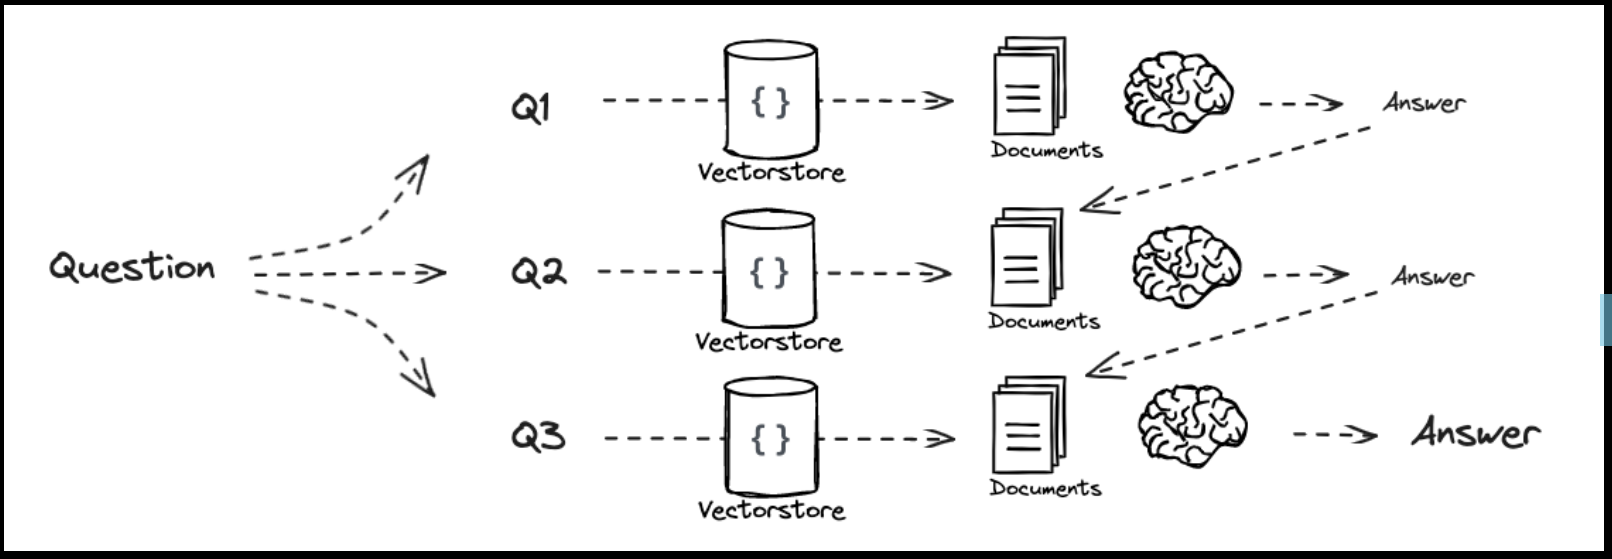

In [20]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [21]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""

    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# llm
llm = ChatGroq(temperature=0)

q_a_pairs = ""
for q in questions:

    rag_chain = (
    {"context": itemgetter("question") | retriever,
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")}
    | decomposition_prompt
    | llm
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [22]:
 answer

'Large Language Models (LLMs) are integrated with other components in an autonomous agent system as the core component, functioning as the "brain" of the agent. They are responsible for processing natural language inputs and generating outputs, enabling the agent to communicate effectively with users and external components.\n\nThe other main components of a language model-based autonomous agent system include Planning, Memory, and a Natural Language Interface. These components work together with the LLM to enable the agent to process natural language inputs, plan and execute tasks, learn from past actions, and maintain context and continuity.\n\nPlanning involves breaking down large tasks into smaller, manageable subgoals and refining past actions for future steps. This enables the agent to handle complex tasks efficiently and improve the quality of final results.\n\nMemory stores and retrieves information for the agent, allowing it to maintain context and continuity in conversations 

# ANSWER INDIVISUALLY
The mixture of agents work this way!

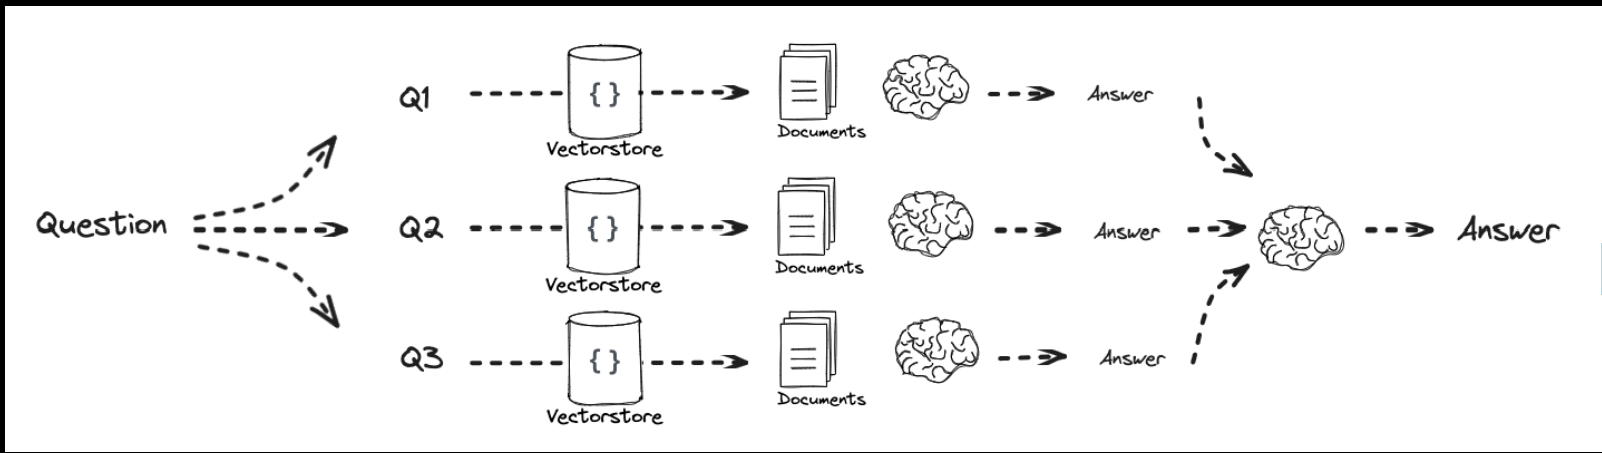

In [23]:
# Answer each sub-question individually

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_groq import ChatGroq

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""

    # Use our decomposition /
    sub_questions = sub_question_generator_chain.invoke({"question":question})

    # Initialize a list to hold RAG chain results
    rag_results = []

    for sub_question in sub_questions:

        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)

        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs,
                                                                "question": sub_question})
        rag_results.append(answer)

    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

<ipython-input-23-8cfa21df09f7>:24: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [24]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""

    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

'The main components of an LLM-powered autonomous agent system include:\n\n1. Large Language Model (LLM): This is the core component of the system, serving as the "brain" of the agent. It oversees planning, subgoal decomposition, reflection, refinement, and memory. The LLM can learn from mistakes and improve future actions, and it can also utilize external tools for problem-solving.\n\n2. Planning: This component includes subgoal decomposition, reflection, and refinement. It helps the agent break down large tasks into smaller, manageable subgoals and learn from past actions to improve future results.\n\n3. Memory: This component is responsible for storing and retrieving information. It allows the agent to access past experiences and use them to inform future actions.\n\nThese components work together to enable the autonomous agent system to understand and interact with its environment, make decisions, and take actions to achieve its goals. Examples of LLM-powered agents include AutoGPT

# STEP BACK
askin a more generic or abstract question

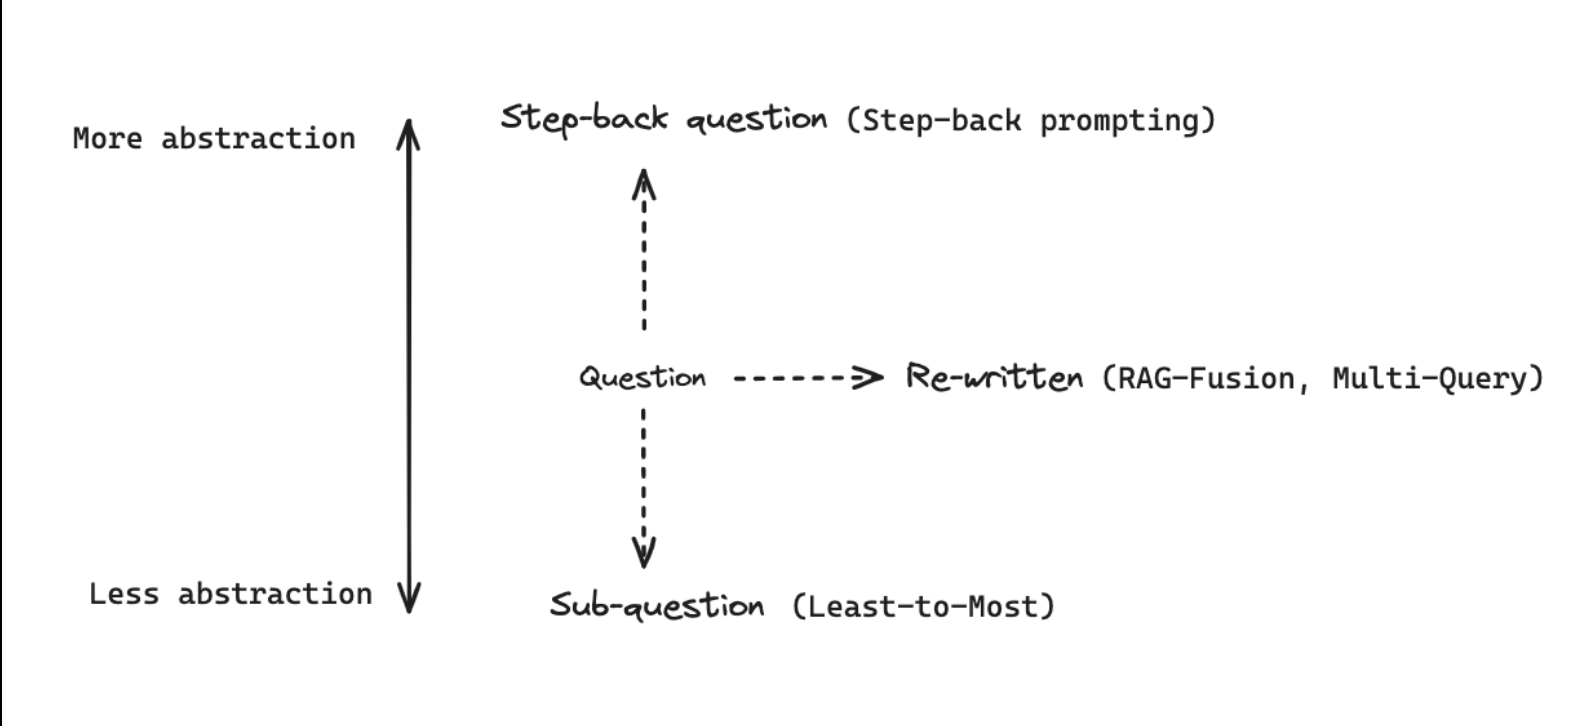

In [25]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
examples = [
    {
        "input": "Could the members of The Police perform lawful arrests?",
        "output": "what can the members of The Police do?",
    },
    {
        "input": "Jan Sindel’s was born in what country?",
        "output": "what is Jan Sindel’s personal history?",
    },
]
# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)
few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back question, which is easier to answer. Here are a few examples:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [26]:
generate_queries_step_back = prompt | ChatGroq(temperature=0) | StrOutputParser()
question = "What is task decomposition for LLM agents?"
generate_queries_step_back.invoke({"question": question})

"how is a large language model agent's task broken down into smaller parts?"

In [27]:
# Response prompt
response_prompt_template = """You are an expert of world knowledge. I am going to ask you a question. Your response should be comprehensive and not contradicted with the following context if they are relevant. Otherwise, ignore them if they are not relevant.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""
response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": lambda x: x["question"],
    }
    | response_prompt
    | ChatGroq(temperature=0)
    | StrOutputParser()
)

chain.invoke({"question": question})

'Task decomposition for LLM agents refers to the process of breaking down a large, complex task into smaller, manageable subgoals. This allows the agent to handle complex tasks more efficiently by focusing on one subgoal at a time.\n\nIn the context of LLM agents, task decomposition is often facilitated by the use of prompting techniques such as Chain of Thought (CoT; Wei et al. 2022). CoT instructs the model to "think step by step" and utilize more test-time computation to decompose hard tasks into smaller and simpler steps. This transforms big tasks into multiple manageable tasks and provides insight into the model\'s thinking process.\n\nIn a LLM-powered autonomous agent system, task decomposition is a component of the planning process (Figure 1 in the document). The agent needs to know what the steps of a task are and plan ahead in order to effectively complete the task.\n\nIt is worth noting that while LLM-based evaluations may conclude that certain models perform similarly, human